In [4]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [5]:
from _moving_average_convergence_divergence import MovingAverageConvergenceDivergence

In [6]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [26]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)

In [24]:
data

,open,high,low,close,volume,currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


In [9]:
df=data["Close"].loc["2018-01-02":]
high=data["High"].loc["2018-01-02":]
low=data["Low"].loc["2018-01-02":]


## Fonction

In [10]:
premier=0 

In [11]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [12]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

## **TEST macd**

In [28]:
macd=MovingAverageConvergenceDivergence(data)

In [29]:
macd=MovingAverageConvergenceDivergence(data)

In [30]:
macd._calculateTi(wl=26,ws=12)

,macd,signal_line
Date,,
2018-01-02,NaN,NaN
2018-01-03,NaN,NaN
2018-01-04,NaN,NaN
2018-01-05,NaN,NaN
2018-01-08,NaN,NaN
...,...,...
2022-03-28,-183.6008,-200.0047
2022-03-29,-170.1133,-194.0264
2022-03-30,-155.2088,-186.2629


In [16]:
macd.getTiSignal()

('hold', 0)

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

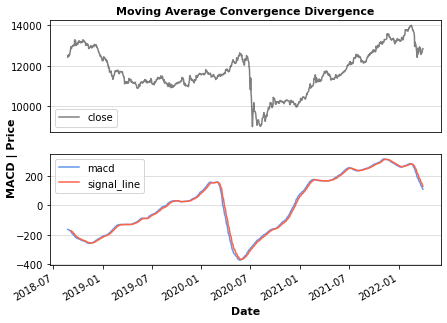

In [18]:
"""
graph = macd.getTiGraph()
st.chi7aja(graph)

In [20]:
macd.getTiSignal()

('hold', 0)

In [31]:
simulation_data, simulation_statistics, simulation_graph = \
macd.getTiSimulation(close_values=df[['Close']], max_exposure=None,short_exposure_factor=1.5)
print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)

KeyError: "None of [Index(['Close'], dtype='object', name='Date')] are in the [index]"

In [32]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [33]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

In [ ]:
def obj_macd(wl):
 macd.calculateTi(df,wl,ws)["macd"]
 wl=int(wl[1])
 ws=int(ws[0])
 print("tf")	
if wl > ws :
	ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	MACD=macd.calculateTi(df,wl,ws)["macd"]
	signal["compa"]=np.nan
	signal["compa"][wl:]=np.where(MACD[wl:]>0 ,1 ,0)
	signal["signal"]=adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=pmv(cours,signal["signal"])
return pmval.max()
	

In [ ]:
def obj_macd2(n):
    macd = MovingAverageConvergenceDivergence(input_data=df)
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	    signal=pd.DataFrame(index=df.index)
	    signal["compa"]=np.nan
        macd.calculateTi(df,wl,ws)[["macd","signal_line"]]
	    signal["compa"][wl:]=np.where(MACD["MACD"][wl:] > MACD["MACDsignal"][wl:] ,1 ,0 )
	    signal["signal"]=adjustsignal(signal["compa"].diff())
	    cours=df*(1+taux*signal["signal"])
	    pmval=at.pmv(cours,signal["signal"])
	    return pmval.max(),

In [ ]:
def obj_mms(n):
    n=int(n[0])
    signal=pd.DataFrame(index=df.index)
    signal['signal']=0
    signal["compa"]=0
    MMS=at.mms(df,n)["MMS"]
    signal["compa"].loc[n:]=np.where(df[n:] > MMS[n:],1,0)
    signal["signal"]=at.adjustsignal(signal["compa"].diff())
    cours=df*(1+taux*signal["signal"])
    pmval=at.pmv(cours,signal["signal"])
    pmval=pd.Series(pmval,index=df.index)
    return pmval.max(), 

In [ ]:
GeneticAlgo(1,obj_mms,10,5,100)

## MMS2

In [ ]:
def obj_mms2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	signal['compa']=np.nan
	signal["MMS_COURT"]=Techni.mms(df,ws)["MMS"]
	signal["MMS_LONG"]=at.mms(df,wl)["MMS"]
	signal["compa"].loc[wl:]=np.where(signal["MMS_COURT"][wl:] > signal["MMS_LONG"][wl:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(2,obj_mms2,6,5,50)

## MACD1

In [ ]:
def obj_macd1(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	MACD=at.macd(df,ws,wl)["MACD"]
	signal["compa"]=np.nan
	signal["compa"][wl:]=np.where(MACD[wl:]>0 ,1 ,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(2,obj_macd1,6,10,60)

## MACD2

In [ ]:
from _technical_indicator import TechnicalIndicator

In [ ]:

import MACD
from MACD import *

In [ ]:
from MACD import *
def obj_macd2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
		signal=pd.DataFrame(index=df.index)
		MACD=_calculateTi(df,ws,wl)[["macd","signal"]]
		
		signal["compa"][wl:]=np.where(MACD["MACD"][wl:] > MACD["MACDsignal"][wl:] ,1 ,0 )
	    signal["signal"]=adjustsignal(signal["compa"].diff())
	    cours=df*(1+taux*signal["signal"])
	    pmval=pmv(cours,signal["signal"])
	    return pmval.max(),

In [ ]:
def obj_macd2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	MACD=at.macd(df,ws,wl)[["MACD","MACDsignal"]]
	signal["compa"][wl:]=np.where(MACD["MACD"][wl:] > MACD["MACDsignal"][wl:] ,1 ,0 )
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(2,obj_macd2,10,12,40)

## Bollinger 

In [ ]:
def obj_bollinger(n):
	global k 
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa2"]=np.nan
	bb=at.bollinger(df,n,k)[["BBDOWN","BBUP"]]
	signal["compa"][n:] = np.where( (df[n:] > bb["BBUP"][n:] ) ,1,0)
	signal["compa2"][n:] = np.where( (df[n:] < bb["BBDOWN"][n:] ) ,4,2)
	signal["signal"]=signal["compa"].diff()
	signal["signal2"]=signal["compa2"].diff()
	sig=np.where(signal["signal"]==1,-1,0)+np.where(signal["signal2"]==2,1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df.index)
	cours=df*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

In [ ]:
k=2
GeneticAlgo(1,obj_bollinger,10,18,35)

In [ ]:
k=2.5
GeneticAlgo(1,obj_bollinger,5,20,60)

In [ ]:
k=3 
GeneticAlgo(1,obj_bollinger,5,20,60)

## RSI

In [ ]:
def  obj_rsi(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	rs=at.rsi(df,n)["RSI"]
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(rs[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(rs[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df.index)
	cours=df*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

In [ ]:
haut,bas=0.7,0.3
GeneticAlgo(1,obj_rsi,5,13,30)

In [ ]:
haut,bas=0.75,0.25
GeneticAlgo(1,obj_rsi,5,13,30)

In [ ]:
haut,bas=0.8,0.20
GeneticAlgo(1,obj_rsi,5,13,30)

In [ ]:
haut,bas=0.85,0.15
GeneticAlgo(1,obj_rsi,6,13,30)

In [ ]:
haut,bas=0.9,0.1
GeneticAlgo(1,obj_rsi,6,13,30)

## Stochastique 1 

In [ ]:
df1=data["COURS_CLOTURE"].loc["2008-01-01":]
high1=data["COURS_PLUS_HAUT"].loc["2008-01-01":]
low1=data["COURS_PLUS_BAS"].loc["2008-01-01":]
vol1=data["Volume_Marche_Bloc"].loc["2008-01-01":] + data["Volume_Marche_Central"].loc["2008-01-01":]

In [ ]:
def obj_stochastique1(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , 3)["%K"]
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(k[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(k[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

In [ ]:
haut,bas=70,30
GeneticAlgo(1,obj_stochastique1,10,12,30)

In [ ]:
haut,bas=75,25
GeneticAlgo(1,obj_stochastique1,6,12,30)

In [ ]:
haut,bas=80,20
GeneticAlgo(1,obj_stochastique1,6,12,30)

In [ ]:
haut,bas=85,15
GeneticAlgo(1,obj_stochastique1,6,12,30)

In [ ]:
haut,bas=90,10
GeneticAlgo(1,obj_stochastique1,6,12,30)

## Stochastique 2

In [ ]:
def obj_stochastique2(n ):
	n.sort()
	w=int(n[0])
	n=int(n[1])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , w)[["%K","%D"]]
	signal["compa"]=np.nan
	signal["compa"][n+w :]=np.where(k["%K"][n+w:] > k["%D"][n+w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(2,obj_stochastique2,6,3,30)

## OBV

In [ ]:
def obj_obv(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	ob=at.obv(df,vol)["OBV"]
	obs=pd.Series(ob.rolling(n).mean(), name='obvsignal')
	signal["compa"]=np.nan 
	signal["compa"][n:]=np.where( ob[n:]  > obs[n:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(1,obj_obv,6,10,100)

## ROC

In [ ]:
def obj_roc(n):
	w=int(n[0])
	signal=pd.DataFrame(index=df.index)
	roc=at.rate_of_change(df,w)["ROC"]
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where( roc[w:]> 0,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(1,obj_roc,10,10,30)

## MFI

In [ ]:
def obj_mfi(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	mfi=at.MFI(df1,vol1,high1,low1,n)['MFI']
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(mfi[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(mfi[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

In [ ]:
haut,bas=80,20
GeneticAlgo(1,obj_mfi,6,10,30)

In [ ]:
haut,bas=70,30
GeneticAlgo(1,obj_mfi,6,10,30)

## CHO

In [ ]:
def obj_cho(ind):
	ind.sort()
	ws=int(ind[0])
	wl=int(ind[1])
	n=int(ind[2])
	signal=pd.DataFrame(index=df1.index)
	signal["compa"]=np.nan 
	ch=at.cho(df1,vol1,high1,low1,n,ws,wl)["CHO"]
	signal["compa"][ws+wl:]=np.where(ch[ws+wl:] > 0, 1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(3,obj_cho,10,3,30)

## NVI

In [ ]:
def obj_nvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	nv=at.nvi(df,vol)
	nvis=pd.Series(nv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(nv[n:] > nvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(1,obj_nvi,5,8,50)

## PVI

In [ ]:
def obj_pvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	pv=at.pvi(df,vol)
	pvis=pd.Series(pv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(pv[n:] > pvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(1,obj_pvi,5,8,50)

In [ ]:
## Momentum 

In [ ]:
def obj_momentum(n):
	w=int(n[0])
	MOM=at.momentum(df,w,wsig=9)[["MOM","MOMsignal"]]
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where(MOM["MOM"][w:] > MOM["MOMsignal"][w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

In [ ]:
GeneticAlgo(1,obj_momentum,5,8,30)